In [1]:
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
dataset_path = "Datasets/edges2shoes/"

In [3]:
buffer_size = 400
batch_size = 1
img_height = 256
img_width = 256

In [4]:
def load_img(image_pth):
    """Load the image file."""
    image = tf.io.read_file(image_pth)
    image = tf.image.decode_jpeg(image)
    
    w = tf.shape(image)[1]
    w = w // 2
    
    real_img = image[:, :w, :]
    real_img = tf.cast(real_img, tf.float32)
    
    input_img = image[:, w:, :]
    input_img = tf.cast(input_img, tf.float32)
    
    return input_img, real_img

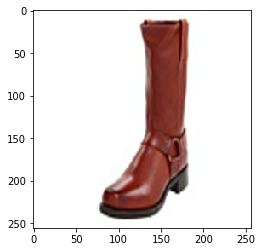

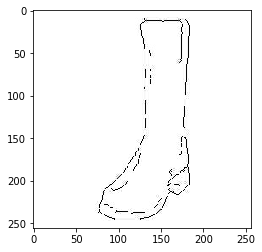

In [5]:
inp, re = load_img(dataset_path + "train/11_AB.jpg")

plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [6]:
def resize_img(input_img, real_img, height, width):
    """Resize the image."""
    input_img = tf.image.resize(input_img, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_img = tf.image.resize(real_img, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_img, real_img

In [11]:
def random_crop(input_img, real_img):
    """Randomly crop the image."""
    stacked_img = tf.stack([input_img, real_img], axis=0)
    cropped_img = tf.image.random_crop(stacked_img, size=[2, img_height, img_width, 3])
    
    return cropped_img[0], cropped_img[1]

In [12]:
# Normalize [-1, 1]
def normalize(input_img, real_img):
    input_img = (input_img / 127.5) - 1.0
    real_img = (real_img / 127.5) - 1.0
    
    return input_img, real_img

In [13]:
# tf.function add the function to graph so can be run on GPU or TPU
@tf.function()
def random_jitter(input_img, real_img):
    """Data augmentation for the photos."""
    input_img, real_img = resize_img(input_img, real_img, 286, 286)
    input_img, real_img = random_crop(input_img, real_img)
    
    # Mirroring with chance of 0.5
    if tf.random.uniform(()) > 0.5:
        input_img = tf.image.flip_left_right(input_img)
        real_img = tf.image.flip_left_right(real_img)
        
    return input_img, real_img

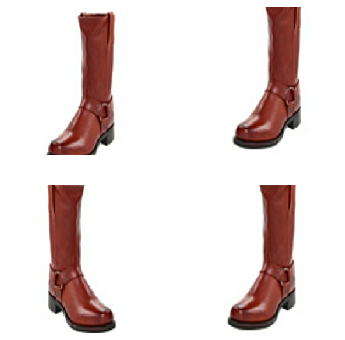

In [14]:
# Test the random jitter function
plt.figure(figsize=(6, 6))
for i in range(4):
    m_inp, m_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(m_inp/255.0)
    plt.axis("off")
plt.show()

In [18]:
def load_img_train(img_file):
    """Load and augment training images."""
    input_img, real_img = load_img(img_file)
    input_img, real_img = random_jitter(input_img, real_img)
    input_img, real_img = normalize(input_img, real_img)
    
    return input_img, real_img

In [19]:
def load_img_test(img_file):
    """Load and augment test images."""
    input_img, real_img = load_img(img_file)
    input_img, real_img = resize_img(input_img, real_img, img_height, img_width)
    input_img, real_img = normalize(input_img, real_img)
    
    return input_img, real_img

In [20]:
train_dataset = tf.data.Dataset.list_files(dataset_path + 'train/*.jpg')
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.map(load_img_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

In [21]:
test_dataset = tf.data.Dataset.list_files(dataset_path + 'val/*.jpg')
test_dataset = test_dataset.shuffle(buffer_size)
test_dataset = test_dataset.map(load_img_test)
test_dataset = test_dataset.batch(1)

In [22]:
output_channels = 3

In [24]:
def downsample(filters, size, apply_batchnorm=True):
    """Encoder block."""
    # Initialize weights
    initializer = tf.random_normal_initializer(0.0, 0.02)
    
    result = tf.keras.Sequential()
    # Add Conv2D layer
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    # Add Batch Normalization layer
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    # Add Leaky ReLU layer
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [25]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [26]:
def upsample(filters, size, apply_dropout=False, use_transpose_conv=True):
    """Decoder block."""
    # Initialize weights
    initializer = tf.random_normal_initializer(0.0, 0.02)
    
    result = tf.keras.Sequential()
    # Add Conv Transpose layer or Upsample layer
    if use_transpose_conv:
        result.add(
            tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                           kernel_initializer=initializer, use_bias=False))
    else:
        result.add(
            tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest'))
        
    # Add Batch Normalization layer
    result.add(tf.keras.layers.BatchNormalization())
    
    # Add ReLU layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU)
    
    return result